# Create learning curves with different models

In [101]:
import os
import pandas as pd 
import numpy as np 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from pyepal.models.nt import build_dense_network
from pyepal.models.gpr import build_model, build_coregionalized_model, predict_coregionalized, predict, get_matern_52_kernel
from pyepal.pal.pal_neural_tangent import _set_one_infinite_width_model, _predict_one_infinite_width_model
from pyepal import get_maxmin_samples


import matplotlib.pyplot as plt

In [14]:
DATADIR = '../data/'

TARGETS = ['deltaGmin', 'A2_normalized']

FEATURES = [
    'num_[W]', 'max_[W]', 'num_[Tr]', 'max_[Tr]', 'num_[Ta]', 'max_[Ta]', 'num_[R]', 'max_[R]', '[W]', '[Tr]', '[Ta]',
    '[R]', 'rel_shannon', 'length'
]

In [15]:
def load_data(n_samples, label_scaling: bool = False):
    """Take in Brian's data and spit out some numpy arrays for the PAL"""
    df_full_factorial_feat = pd.read_csv(os.path.join(DATADIR, 'new_features_full_random.csv'))[FEATURES].values
    a2 = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_virial_large_new.csv'))['A2_normalized'].values
    deltaGMax = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_virial_large_new.csv'))['A2_normalized'].values  # pylint:disable=unused-variable
    gibbs = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_deltaG.csv'))['deltaGmin'].values * (-1)
    gibbs_max = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_virial_large_new.csv'))['deltaGmax'].values
    force_max = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_virial_large_fit2.csv'))['F_repel_max'].values  # pylint:disable=unused-variable
    rg = pd.read_csv(os.path.join(DATADIR, 'rg_results.csv'))['Rg'].values
    y = np.hstack([rg.reshape(-1, 1), gibbs.reshape(-1, 1), gibbs_max.reshape(-1, 1)])
    assert len(df_full_factorial_feat) == len(a2) == len(gibbs) == len(y)

    feat_scaler = StandardScaler()
    X = feat_scaler.fit_transform(df_full_factorial_feat)

    if label_scaling:
        label_scaler = MinMaxScaler()
        y = label_scaler.fit_transform(y)

    greedy_indices = get_maxmin_samples(X, n_samples)

    return X, y, greedy_indices

In [16]:
X, y, _ = load_data(10)

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.4)

X_scaler = StandardScaler()
X_train = X_scaler.fit_transform(X_train)
X_test = X_scaler.transform(X_test)

y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train)
y_test = y_scaler.transform(y_test)

## 1. Test building the models before we loop over them

### 1.1. Neural tangent

In [111]:
nt_models = [build_dense_network([8,8,8]), build_dense_network([8,8,8]), build_dense_network([8,8,8])]

In [112]:
for i, model in enumerate(nt_models):
    model.predict_fn = _set_one_infinite_width_model(i, nt_models, X_train, y_train, sampled = np.array([[True, True, True]]*len(y_train)))[0]

In [113]:
nt_nngp_predictions = []
nt_ntk_predictions = []

for i, model in enumerate(nt_models):
    nt_nngp_predictions.append(_predict_one_infinite_width_model(i, nt_models, X_test, 'nngp'))
    nt_ntk_predictions.append(_predict_one_infinite_width_model(i, nt_models, X_test, 'ntk'))

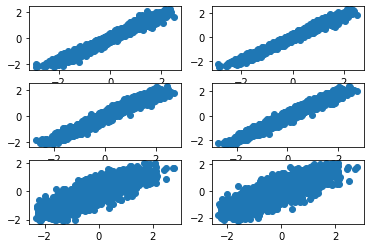

In [114]:
fig, ax = plt.subplots(3,2)

ax[0,0].scatter(y_test[:,0], nt_ntk_predictions[0][0])
ax[0,1].scatter(y_test[:,0], nt_nngp_predictions[0][0])

ax[1,0].scatter(y_test[:,1], nt_ntk_predictions[1][0])
ax[1,1].scatter(y_test[:,1], nt_nngp_predictions[1][0])

ax[2,0].scatter(y_test[:,2], nt_ntk_predictions[2][0])
ax[2,1].scatter(y_test[:,2], nt_nngp_predictions[2][0])

## 1.2. Coregionalized GPR

In [115]:
coregionalized_model_rank_1 = build_coregionalized_model(X_train, y_train, kernel=get_matern_52_kernel(X_train.shape[1], ARD=False), w_rank=1)
coregionalized_model_rank_2 = build_coregionalized_model(X_train, y_train, kernel=get_matern_52_kernel(X_train.shape[1], ARD=False), w_rank=2)

In [ ]:
coregionalized_model_rank_1.optimize_restarts(20)
coregionalized_model_rank_2.optimize_restarts(20)

Optimization restart 1/20, f = -106.77820953843093
Optimization restart 2/20, f = -106.77848065360786
Optimization restart 3/20, f = -106.77817096132458
Optimization restart 4/20, f = -106.77847009876791
Optimization restart 5/20, f = -106.77849997440217
Optimization restart 6/20, f = -106.77848179202101
Optimization restart 7/20, f = -106.77846038389043
Optimization restart 8/20, f = -106.77849380651696
Optimization restart 9/20, f = -106.77845621520237
Optimization restart 10/20, f = -106.7784750912208
Optimization restart 11/20, f = -106.77850119824893
Optimization restart 12/20, f = -106.77799963559755
Optimization restart 13/20, f = -106.77847318105546
Optimization restart 14/20, f = -106.77781303604434
Optimization restart 15/20, f = -106.77839875182826
Optimization restart 16/20, f = -106.77843386671839
Optimization restart 17/20, f = -106.77848285070559
Optimization restart 18/20, f = -106.77831407395956


In [ ]:
coregionalized_model_rank_2.ICM

In [ ]:
coregionalized_model_rank_1.ICM

In [103]:
coregionalized_rank_1_predictions = []
coregionalized_rank_2_predictions = []

for i in range(3):
    coregionalized_rank_1_predictions.append(predict_coregionalized(coregionalized_model_rank_1, X_test, i))
    coregionalized_rank_2_predictions.append(predict_coregionalized(coregionalized_model_rank_2, X_test, i))

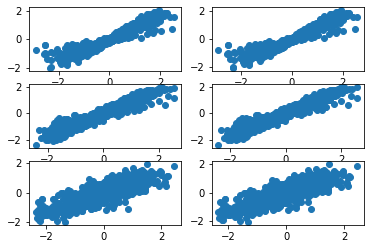

In [105]:
fig, ax = plt.subplots(3,2)

ax[0,0].scatter(y_test[:,0], coregionalized_rank_1_predictions[0][0])
ax[0,1].scatter(y_test[:,0], coregionalized_rank_2_predictions[0][0])

ax[1,0].scatter(y_test[:,1], coregionalized_rank_1_predictions[1][0])
ax[1,1].scatter(y_test[:,1], coregionalized_rank_2_predictions[1][0])

ax[2,0].scatter(y_test[:,2], coregionalized_rank_1_predictions[2][0])
ax[2,1].scatter(y_test[:,2], coregionalized_rank_2_predictions[2][0])

## 1.3. Non-coregionalized GPR